In [1]:
import numpy as np
import pandas as pd

from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer
from w2v import train_word2vec 
import pickle, datetime
import difflib

import keras
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.utils import np_utils
from keras.layers import Input, Dense, Dropout, Flatten, Embedding, regularizers
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.merge import Concatenate
from keras import optimizers
from keras.preprocessing import sequence
from keras import backend as K
import re
np.random.seed(0)

Using TensorFlow backend.


## Load Data

In [2]:
fname = '../../Datasets/SST1_dataset/sst_data'
with open(fname, 'rb') as file:
    data = pickle.load(file)
    
x_train, y_train, x_test, y_test, dictionary = data
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(9645, 37) (9645, 5) (2210, 37) (2210, 5)


# -------------------------------- Training model  -----------------------------------

### Model Paremeters

In [3]:
model_type    = 'CNN-non-static'  # CNN-rand|CNN-non-static|CNN-static
embedding_dim = 300         # word2vec dim
vocab_size    = len(dictionary.token2id) + 1
max_sent_len  = dictionary.seq_len
N_CATEGORY    = 5

### Generate word2vec 

In [4]:
if model_type in ['CNN-non-static', 'CNN-static']:
    embedding_wts = train_word2vec( np.vstack((x_train, x_test)), 
                                    dictionary.id2token, num_features = embedding_dim)
    if model_type == 'CNN-static':
        x_train = embedding_wts[0][x_train]
        x_test  = embedding_wts[0][x_test]
        
elif model_type == 'CNN-rand':
    embedding_wts = None
    
else:
    raise ValueError("Unknown model type")

Load existing Word2Vec model '300features_1minwords_10context'


### Create model

In [5]:
filter_sizes = [3,4,5]
num_filters  = 100
dropout_prob = (0.5, 0.8)
hidden_dims  = 100
batch_size   = 50
l2_reg = 0.3

# Deciding dimension of input based on the model
input_shape = (max_sent_len, embedding_dim) if model_type == "CNN-static" else (max_sent_len,)
model_input = Input(shape = input_shape)

# Static model do not have embedding layer
if model_type == "CNN-static":
    z = Dropout(dropout_prob[0])(model_input)
else:
    z = Embedding(vocab_size, embedding_dim, input_length = max_sent_len, name="embedding", trainable=True)(model_input)
    z = Dropout(dropout_prob[0])(z)

# Convolution layers
z1 = Conv1D(    filters=num_filters, kernel_size=filter_sizes[0], 
                padding="valid", activation="relu", 
                strides=1)(z)
z1 = MaxPooling1D(pool_size = int(max_sent_len - filter_sizes[0] + 1))(z1)
z1 = Flatten()(z1)

z2 = Conv1D(    filters=num_filters, kernel_size=filter_sizes[1], 
                padding="valid", activation="relu", 
                strides=1)(z)
z2 = MaxPooling1D(pool_size= int(max_sent_len - filter_sizes[1] + 1))(z2)
z2 = Flatten()(z2)

z3 = Conv1D(    filters=num_filters, kernel_size=filter_sizes[2], 
                padding="valid", activation="relu",
                strides=1)(z)
z3 = MaxPooling1D(pool_size= int(max_sent_len - filter_sizes[2] + 1))(z3)
z3 = Flatten()(z3)

# Concatenate the output of all convolution layers
z = Concatenate()([z1, z2, z3])
z = Dropout(dropout_prob[1])(z)

z = Dense(hidden_dims, activation="relu")(z)
model_output = Dense( N_CATEGORY, activation="softmax")(z)
    
model = Model(model_input, model_output)

if model_type == "CNN-non-static":
    embedding_layer = model.get_layer("embedding")
    embedding_layer.set_weights(embedding_wts)

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 37)            0                                            
____________________________________________________________________________________________________
embedding (Embedding)            (None, 37, 300)       3597600                                      
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 37, 300)       0                                            
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 35, 100)       90100                                        
___________________________________________________________________________________________

### Train model 

In [6]:
from sklearn.metrics import roc_auc_score
import time
import pylab as pl
from IPython import display
pl.style.use('ggplot')
%matplotlib inline

class Histories(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.acc = []
        self.loss = []
        self.val_loss = []
        self.val_acc = []

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        self.acc.append(logs['acc'])
        self.loss.append(logs['loss'])
        self.val_acc.append(logs['val_acc'])
        self.val_loss.append(logs['val_loss'])
        
        pl.hold(True)
        pl.plot(self.acc, 'r')
        pl.plot(self.loss, 'g')
        pl.plot(self.val_acc, 'b')
        pl.plot(self.val_loss, 'k')
        pl.legend(['Train acc','Train loss','Valid acc', 'Valid loss'], loc=2)
        display.clear_output(wait=True)
        display.display(pl.gcf())
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [7]:
count = 1

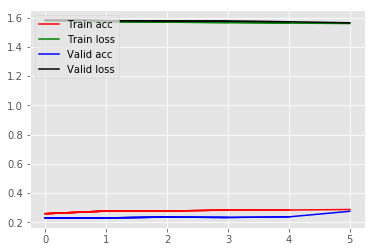

2s - loss: 1.5588 - acc: 0.2882 - val_loss: 1.5640 - val_acc: 0.2760
Epoch 7/400


In [ ]:
count += 1
model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(), metrics=["accuracy"])

histories = Histories()
res = model.fit(x_train, y_train, 
          batch_size = batch_size,
          epochs=400,
          validation_data=(x_test, y_test), verbose=2, callbacks=[histories])

### Computing Accuracy

In [15]:
scores = model.evaluate(x_train, y_train, verbose=0)
print("Train Accuracy: %.2f%%" % (scores[1]*100))
scores = model.evaluate(x_test, y_test, verbose=0)
print("Test Accuracy: %.2f%%" % (scores[1]*100))

Train Accuracy: 35.28%
Test Accuracy: 30.63%


### Save the model

In [11]:
def load_model(fname):
    model = keras.models.model_from_json(open(fname + '.json').read())
    model.load_weights(fname + '_weights.h5')
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=["accuracy"])
    return model

def save_model(model, fname):    
    json_string = model.to_json()
    open(fname + '.json', 'w').write(json_string)
    model.save_weights(fname + '_weights.h5', overwrite=True)
    with open( fname + '_history', 'wb') as output:
        pickle.dump([model.history.history], output, pickle.HIGHEST_PROTOCOL)

In [54]:
fname = './yoyo_cnn_non_static' + str(count)
save_model(model, fname)

In [9]:
fname = 'yoyo_cnn_non_static5'

In [14]:
model = load_model(fname)